<a href="https://colab.research.google.com/github/milvus-io/bootcamp/blob/master/bootcamp/RAG/advanced_rag/langgraph-graphrag-agent-local.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -U langchain_community arxiv tiktoken langchainhub pymilvus langchain langgraph tavily-python sentence-transformers langchain-milvus langchain-ollama langchain-huggingface beautifulsoup4 langchain-experimental neo4j json-repair langchain-openai langchain-ollama

# LangGraph GraphRAG agent with Llama 3.x and GPT4o


Let's build an Advanced RAG with a GraphRAG agent that will run a combination of Llama 3.1 and GPT4o, for Llama 3.1 we will use Ollama. The idea is that we use GPT4o for advanced tasks, like generating the Neo4j query and Llama3.1 for the rest. 

## Ideas

We'll combine ideas from three RAG papers into a RAG agent:

- **Routing:**  Adaptive RAG ([paper](https://arxiv.org/abs/2403.14403)). Route questions to different retrieval approaches
- **Fallback:** Corrective RAG ([paper](https://arxiv.org/pdf/2401.15884.pdf)). Fallback to web search if docs are not relevant to query
- **Self-correction:** Self-RAG ([paper](https://arxiv.org/abs/2310.11511)). Fix answers w/ hallucinations or don’t address question

![langgraph_adaptive_rag.png](imgs/RAG_Agent_langGraph.png)

Note that this will incorperate [a few general ideas for agents](https://www.deeplearning.ai/the-batch/how-agents-can-improve-llm-performance/):

- **Reflection**: The self-correction mechanism is a form of reflection, where the LangGraph agent reflects on its retrieval and generations
- **Planning**: The control flow laid out in the graph is a form of planning 
- **Tool use**: Specific nodes in the control flow (e.g., web search) will use tools

## Local models

### LLM

Use [Ollama](https://ollama.ai/) and [llama3](https://ollama.ai/library/llama3):

```
ollama pull llama3.1
```

### Env Variables
Variables needed in an .env file or loaded as variables at start:

Required:
```
OPENAI_API_KEY=sk-...
TAVILY_API_KEY=tvly-...
NEO4J_URI=...
NEO4J_USERNAME=...
NEO4J_PASSWORD=...
```

### Search

Uses [Tavily](https://tavily.com/#api)

In [55]:
from dotenv import load_dotenv
import os

load_dotenv()

True

In [56]:
from langchain.globals import set_verbose, set_debug

set_debug(False)
set_verbose(False)

In [57]:
### LLM

local_llm = "llama3.1"

In [4]:
import arxiv

search_query = "agent OR 'large language model' OR 'prompt engineering'"
max_results = 20

client = arxiv.Client()
search = arxiv.Search(
    query=search_query, max_results=max_results, sort_by=arxiv.SortCriterion.Relevance
)

In [37]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_milvus import Milvus
from langchain_community.embeddings import HuggingFaceEmbeddings


docs = []
for result in client.results(search):
    docs.append(
        {"title": result.title, "summary": result.summary, "url": result.entry_id}
    )

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=50
)
doc_splits = text_splitter.create_documents(
    [doc["summary"] for doc in docs], metadatas=docs
)

print(f"Number of papers: {len(docs)}")
print(f"Number of chunks: {len(doc_splits)}")


# Add to Milvus
vectorstore = Milvus.from_documents(
    documents=doc_splits,
    collection_name="rag_milvus",
    embedding=HuggingFaceEmbeddings(),
    connection_args={"uri": "./milvus_ingest_v2.db"},
)
retriever = vectorstore.as_retriever()

Number of papers: 20
Number of chunks: 20


/var/folders/kv/3dw9p_ts4b114chqt9m027pc0000gn/T/ipykernel_10082/2843254102.py:28: LangChainDeprecationWarning: Default values for HuggingFaceEmbeddings.model_name were deprecated in LangChain 0.2.16 and will be removed in 0.4.0. Explicitly pass a model_name to the HuggingFaceEmbeddings constructor instead.
  embedding=HuggingFaceEmbeddings(),
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [38]:
from langchain_community.chat_models import ChatOllama

llm = ChatOllama(model=local_llm, format="json", temperature=0)

In [9]:
# GraphRAG Setup
from langchain_community.graphs import Neo4jGraph
from langchain_experimental.graph_transformers import LLMGraphTransformer
from langchain_core.documents import Document
from langchain_experimental.llms.ollama_functions import OllamaFunctions
from langchain_experimental.graph_transformers.diffbot import DiffbotGraphTransformer
from langchain_openai import ChatOpenAI
from langchain_ollama import ChatOllama

graph = Neo4jGraph()

graph_llm = ChatOpenAI(temperature=0, model_name="gpt-4o")

graph_transformer = LLMGraphTransformer(
    llm=graph_llm,
    allowed_nodes=["Paper", "Author", "Topic"],
    node_properties=["title", "summary", "url"],
    allowed_relationships=["AUTHORED", "DISCUSSES", "RELATED_TO"],
)

graph_documents = graph_transformer.convert_to_graph_documents(doc_splits)

graph.add_graph_documents(graph_documents)

print(f"Graph documents: {len(graph_documents)}")
print(f"Nodes from 1st graph doc:{graph_documents[0].nodes}")
print(f"Relationships from 1st graph doc:{graph_documents[0].relationships}")

Graph documents: 20
Nodes from 1st graph doc:[Node(id='Prompt Design And Engineering', type='Topic'), Node(id='Large Language Models', type='Topic'), Node(id='Chain-Of-Thought', type='Topic'), Node(id='Reflection', type='Topic'), Node(id='Llm-Based Agents', type='Topic'), Node(id='Tools For Prompt Engineers', type='Topic'), Node(id='This Paper', type='Paper', properties={'summary': 'This paper introduces core concepts, advanced techniques like Chain-of-Thought and Reflection, and the principles behind building LLM-based agents. It also provides a survey of tools for prompt engineers.'})]
Relationships from 1st graph doc:[Relationship(source=Node(id='This Paper', type='Paper'), target=Node(id='Prompt Design And Engineering', type='Topic'), type='DISCUSSES'), Relationship(source=Node(id='This Paper', type='Paper'), target=Node(id='Large Language Models', type='Topic'), type='DISCUSSES'), Relationship(source=Node(id='This Paper', type='Paper'), target=Node(id='Chain-Of-Thought', type='Top

In [39]:
# After converting to graph documents
for i, doc in enumerate(graph_documents):
    print(f"Document {i}:")
    print(f"  Nodes: {doc.nodes}")
    print(f"  Relationships: {doc.relationships}")
    print("---")

Document 0:
  Nodes: [Node(id='Prompt Design And Engineering', type='Topic'), Node(id='Large Language Models', type='Topic'), Node(id='Chain-Of-Thought', type='Topic'), Node(id='Reflection', type='Topic'), Node(id='Llm-Based Agents', type='Topic'), Node(id='Tools For Prompt Engineers', type='Topic'), Node(id='This Paper', type='Paper', properties={'summary': 'This paper introduces core concepts, advanced techniques like Chain-of-Thought and Reflection, and the principles behind building LLM-based agents. It also provides a survey of tools for prompt engineers.'})]
  Relationships: [Relationship(source=Node(id='This Paper', type='Paper'), target=Node(id='Prompt Design And Engineering', type='Topic'), type='DISCUSSES'), Relationship(source=Node(id='This Paper', type='Paper'), target=Node(id='Large Language Models', type='Topic'), type='DISCUSSES'), Relationship(source=Node(id='This Paper', type='Paper'), target=Node(id='Chain-Of-Thought', type='Topic'), type='DISCUSSES'), Relationship(so

In [40]:
### Retrieval Grader

from langchain.prompts import PromptTemplate
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import JsonOutputParser

# LLM
llm = ChatOllama(model=local_llm, format="json", temperature=0)

prompt = PromptTemplate(
    template="""You are a grader assessing relevance 
    of a retrieved document to a user question. If the document contains keywords related to the user question, 
    grade it as relevant. It does not need to be a stringent test. The goal is to filter out erroneous retrievals. 
    
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.
    Provide the binary score as a JSON with a single key 'score' and no premable or explaination.
     
    Here is the retrieved document: 
    {document}
    
    Here is the user question: 
    {question}
    """,
    input_variables=["question", "document"],
)

retrieval_grader = prompt | llm | JsonOutputParser()
question = "Do we have articles that talk about Prompt Engineering?"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(
    f'Is our answer relevant to the question asked: {retrieval_grader.invoke({"question": question, "document": doc_txt})}'
)

Is our answer relevant to the question asked: {'score': 'yes'}


In [41]:
### Generate

from langchain.prompts import PromptTemplate
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

prompt = PromptTemplate(
    template="""You are an assistant for question-answering tasks. 
    Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. 
    Use three sentences maximum and keep the answer concise:
    Question: {question} 
    Context: {context} 
    Answer: 
    """,
    input_variables=["question", "document"],
)

llm = ChatOllama(model=local_llm, temperature=0)


def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


rag_chain = prompt | llm | StrOutputParser()

question = "Do we have articles that talk about Prompt Engineering?"
docs = retriever.invoke(question)
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

Yes, we have articles that talk about Prompt Engineering. The context includes papers discussing core concepts, advanced techniques, and principles behind building Large Language Model (LLM)-based agents, as well as a survey of tools for prompt engineers. Additionally, there are studies on prompt engineering technologies to improve the quality of model outputs and proposed attacks against LLMs that aim to steal well-designed prompts.


In [42]:
### Graph Generate

from langchain.prompts import PromptTemplate
from langchain.chains import GraphCypherQAChain
from langchain_ollama import ChatOllama
from langchain_openai import ChatOpenAI


cypher_prompt = PromptTemplate(
    template="""You are an expert at generating Cypher queries for Neo4j.
    Use the following schema to generate a Cypher query that answers the given question.
    Make the query flexible by using case-insensitive matching and partial string matching where appropriate.
    Focus on searching paper titles as they contain the most relevant information.
    
    Schema:
    {schema}
    
    Question: {question}
    
    Cypher Query:""",
    input_variables=["schema", "question"],
)


qa_prompt = PromptTemplate(
    template="""You are an assistant for question-answering tasks. 
    Use the following Cypher query results to answer the question. If you don't know the answer, just say that you don't know. 
    Use three sentences maximum and keep the answer concise. If topic information is not available, focus on the paper titles.
    
    Question: {question} 
    Cypher Query: {query}
    Query Results: {context} 
    
    Answer:""",
    input_variables=["question", "query", "context"],
)

llm = ChatOpenAI(model="gpt-4o", temperature=0)

graph_rag_chain = GraphCypherQAChain.from_llm(
    cypher_llm=llm,
    qa_llm=llm,
    validate_cypher=True,
    graph=graph,
    verbose=True,
    return_intermediate_steps=True,
    return_direct=True,
    cypher_prompt=cypher_prompt,
    qa_prompt=qa_prompt,
)

question = "What paper talks about Multi-Agent?"
generation = graph_rag_chain.invoke({"query": question})
print(generation)



> Entering new GraphCypherQAChain chain...


Failed to write data to connection ResolvedIPv4Address(('35.241.237.34', 7687)) (ResolvedIPv4Address(('35.241.237.34', 7687)))
Failed to write data to connection IPv4Address(('a154a864.databases.neo4j.io', 7687)) (ResolvedIPv4Address(('35.241.237.34', 7687)))


Generated Cypher:
cypher
MATCH (p:Paper)
WHERE toLower(p.title) CONTAINS toLower("Multi-Agent")
RETURN p.title, p.id


> Finished chain.
{'query': 'What paper talks about Multi-Agent?', 'result': [{'p.title': 'Multi-Agent Assistant Code Generation (AgentCoder)', 'p.id': 'Multi-Agent Assistant Code Generation (Agentcoder)'}, {'p.title': 'Framework for Automatically Generating Process Models with Multi-Agent Orchestration (MAO)', 'p.id': 'This Article'}, {'p.title': 'Collaborative Multi-Agent, Multi-Reasoning-Path (CoMM) Prompting Framework', 'p.id': 'This Work'}], 'intermediate_steps': [{'query': 'cypher\nMATCH (p:Paper)\nWHERE toLower(p.title) CONTAINS toLower("Multi-Agent")\nRETURN p.title, p.id\n'}]}


In [43]:
### Composite Vector + Graph Generations

from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain.chains.base import Chain


prompt = PromptTemplate(
    template="""You are an assistant for question-answering tasks. 
    Use the following pieces of retrieved context from a vector store and a graph database to answer the question. If you don't know the answer, just say that you don't know. 
    Use three sentences maximum and keep the answer concise:
    Question: {question} 
    Vector Context: {context} 
    Graph Context: {graph_context}
    Answer: 
    """,
    input_variables=["question", "context", "graph_context"],
)

llm = ChatOllama(model=local_llm, temperature=0)

# Example input data
question = "What paper talk about Multi-Agent?"

In [44]:
# Get vector + graph answers
docs = retriever.invoke(question)

print(docs)

[Document(metadata={'pk': 453568971862704139, 'summary': 'Leveraging multiple large language model (LLM) agents has shown to be a\npromising approach for tackling complex tasks, while the effective design of\nmultiple agents for a particular application remains an art. It is thus\nintriguing to answer a critical question: Given a task, how can we build a team\nof LLM agents to solve it effectively? Our new adaptive team-building paradigm\noffers a flexible solution, realized through a novel agent design named Captain\nAgent. It dynamically forms and manages teams for each step of a task-solving\nprocess, utilizing nested group conversations and reflection to ensure diverse\nexpertise and prevent stereotypical outputs, allowing for a flexible yet\nstructured approach to problem-solving. A comprehensive evaluation across six\nreal-world scenarios demonstrates that Captain Agent significantly outperforms\nexisting multi-agent methods with 21.94% improvement in average accuracy,\nproviding

In [45]:
vector_context = rag_chain.invoke({"context": docs, "question": question})

print(vector_context)

The papers that talk about Multi-Agent are:

* "Adaptive In-conversation Team Building for Language Model Agents"
* "Drama Engine: A Framework for Narrative Agents"
* "Exploring the Intersection of Large Language Models and Agent-Based Modeling via Prompt Engineering"
* "On the Discussion of Large Language Models: Symmetry of Agents and Interplay with Prompts"

These papers discuss various aspects of multi-agent systems, including team building, narrative agents, simulations of human interactions, and discussion mechanisms.


In [46]:
graph_context = graph_rag_chain.invoke({"query": question})

print(graph_context)



> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Paper)
WHERE toLower(p.title) CONTAINS toLower("multi-agent")
RETURN p.title, p.id


> Finished chain.
{'query': 'What paper talk about Multi-Agent?', 'result': [{'p.title': 'Multi-Agent Assistant Code Generation (AgentCoder)', 'p.id': 'Multi-Agent Assistant Code Generation (Agentcoder)'}, {'p.title': 'Framework for Automatically Generating Process Models with Multi-Agent Orchestration (MAO)', 'p.id': 'This Article'}, {'p.title': 'Collaborative Multi-Agent, Multi-Reasoning-Path (CoMM) Prompting Framework', 'p.id': 'This Work'}], 'intermediate_steps': [{'query': 'cypher\nMATCH (p:Paper)\nWHERE toLower(p.title) CONTAINS toLower("multi-agent")\nRETURN p.title, p.id\n'}]}


In [47]:
composite_chain = prompt | llm | StrOutputParser()
answer = composite_chain.invoke(
    {"question": question, "context": vector_context, "graph_context": graph_context}
)

print(answer)

The papers that talk about Multi-Agent are:

* "Adaptive In-conversation Team Building for Language Model Agents"
* "Drama Engine: A Framework for Narrative Agents"
* "Exploring the Intersection of Large Language Models and Agent-Based Modeling via Prompt Engineering"
* "On the Discussion of Large Language Models: Symmetry of Agents and Interplay with Prompts"

These papers discuss various aspects of multi-agent systems, including team building, narrative agents, simulations of human interactions, and discussion mechanisms.


In [48]:
### Hallucination Grader

llm = ChatOllama(model=local_llm, format="json", temperature=0)

prompt = PromptTemplate(
    template="""You are a grader assessing whether 
    an answer is grounded in / supported by a set of facts. Give a binary score 'yes' or 'no' score to indicate 
    whether the answer is grounded in / supported by a set of facts. Provide the binary score as a JSON with a 
    single key 'score' and no preamble or explanation.
    
    Here are the facts:
    {documents} 

    Here is the answer: 
    {generation}
    """,
    input_variables=["generation", "documents"],
)

hallucination_grader = prompt | llm | JsonOutputParser()
hallucination_grader.invoke({"documents": docs, "generation": generation})

{'score': 'yes'}

In [49]:
### Answer Grader

llm = ChatOllama(model=local_llm, format="json", temperature=0)

prompt = PromptTemplate(
    template="""You are a grader assessing whether an 
    answer is useful to resolve a question. Give a binary score 'yes' or 'no' to indicate whether the answer is 
    useful to resolve a question. Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.
     
    Here is the answer:
    {generation} 

    Here is the question: {question}
    """,
    input_variables=["generation", "question"],
)

answer_grader = prompt | llm | JsonOutputParser()
answer_grader.invoke({"question": question, "generation": generation})

{'score': 'yes'}

In [50]:
### Router

from langchain.prompts import PromptTemplate
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import JsonOutputParser

llm = ChatOllama(model=local_llm, format="json", temperature=0)

prompt = PromptTemplate(
    template="""You are an expert at routing a user question to the most appropriate data source. 
    You have three options:
    1. 'vectorstore': Use for questions about LLM agents, prompt engineering, and adversarial attacks.
    2. 'graphrag': Use for questions that involve relationships between entities, such as authors, papers, and topics, or when the question requires understanding connections between concepts.
    3. 'web_search': Use for all other questions or when current information is needed.

    You do not need to be stringent with the keywords in the question related to these topics. 
    Choose the most appropriate option based on the nature of the question.

    Return a JSON with a single key 'datasource' and no preamble or explanation. 
    The value should be one of: 'vectorstore', 'graphrag', or 'web_search'.
    
    Question to route: 
    {question}""",
    input_variables=["question"],
)

question_router = prompt | llm | JsonOutputParser()
question = "llm agent memory"
docs = retriever.get_relevant_documents(question)
doc_txt = docs[1].page_content
print(question_router.invoke({"question": question}))

{'datasource': 'vectorstore'}


In [51]:
### Search

from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

We'll implement these as a control flow in LangGraph.

In [52]:
from typing_extensions import TypedDict
from typing import List

### State
class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents
        graph_context: results from graph search
    """

    question: str
    generation: str
    web_search: str
    documents: List[str]
    graph_context: str


from langchain.schema import Document

### Nodes
def retrieve(state):
    """
    Retrieve documents from vectorstore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}


def generate(state):
    """
    Generate answer using RAG on retrieved documents and graph context

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state.get("documents", [])
    graph_context = state.get("graph_context", "")

    # Composite RAG generation
    generation = composite_chain.invoke(
        {"question": question, "context": documents, "graph_context": graph_context}
    )
    return {
        "documents": documents,
        "question": question,
        "generation": generation,
        "graph_context": graph_context,
    }


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question
    If any document is not relevant, we will set a flag to run web search

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Filtered out irrelevant documents and updated web_search state
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score["score"]
        # Document relevant
        if grade.lower() == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        # Document not relevant
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            # We do not include the document in filtered_docs
            # We set a flag to indicate that we want to run web search
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "question": question, "web_search": web_search}


def web_search(state):
    """
    Web search based on the question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Appended web results to documents
    """

    print("---WEB SEARCH---")
    question = state["question"]
    documents = state.get("documents", [])  # Use get() with a default empty list

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)

    return {"documents": documents, "question": question}


### Conditional edge
def route_question(state):
    print("---ROUTE QUESTION---")
    question = state["question"]
    print(question)
    source = question_router.invoke({"question": question})
    print(source)
    print(source["datasource"])

    if source["datasource"] == "graphrag":
        print("---TRYING GRAPH SEARCH---")
        graph_result = graph_search({"question": question})
        if graph_result["graph_context"] != "No results found in the graph database.":
            return "graphrag"
        else:
            print("---NO RESULTS IN GRAPH, FALLING BACK TO VECTORSTORE---")
            return "retrieve"
    elif source["datasource"] == "vectorstore":
        print("---ROUTE QUESTION TO VECTORSTORE RAG---")
        return "retrieve"
    elif source["datasource"] == "web_search":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "websearch"


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or add web search

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    question = state["question"]
    web_search = state["web_search"]
    filtered_documents = state["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH---"
        )
        return "websearch"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


def graph_search(state):
    """
    Perform GraphRAG search using Neo4j

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updated state with graph search results
    """
    print("---GRAPH SEARCH---")
    question = state["question"]

    # Use the graph_rag_chain to perform the search
    result = graph_rag_chain.invoke({"query": question})

    # Extract the relevant information from the result
    # Adjust this based on what graph_rag_chain returns
    graph_context = result.get("result", "")

    # You might want to combine this with existing documents or keep it separate
    return {"graph_context": graph_context, "question": question}


### Conditional edge
def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = grade = score.get("score", "").lower()

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score["score"]
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"


from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("websearch", web_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("graphrag", graph_search)

### Graph Build

In [53]:
# Set conditional entry point
workflow.set_conditional_entry_point(
    route_question,
    {
        "websearch": "websearch",
        "retrieve": "retrieve",
        "graphrag": "graphrag",
    },
)

# Add edges
workflow.add_edge("retrieve", "grade_documents")
workflow.add_edge("graphrag", "generate")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "websearch": "websearch",
        "generate": "generate",
    },
)
workflow.add_edge("websearch", "generate")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "websearch",
    },
)

In [54]:
# Compile
app = workflow.compile()

# Test
from pprint import pprint

inputs = {"question": "What are the types of Prompt Engineering?"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

---ROUTE QUESTION---
What are the types of Prompt Engineering?
{'datasource': 'vectorstore'}
vectorstore
---ROUTE QUESTION TO VECTORSTORE RAG---
---RETRIEVE---
'Finished running: retrieve:'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
'Finished running: grade_documents:'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---
'Finished running: generate:'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---
'Finished running: generate:'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---
'Finished running: generate:'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---
'Finished running: generate:'
---GENE

KeyboardInterrupt: 

In [58]:
# Compile
app = workflow.compile()

# Test
from pprint import pprint

inputs = {"question": "Did Emmanuel Macron visit Germany recently?"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

---ROUTE QUESTION---
Did Emmanuel Macron visit Germany recently?
{'datasource': 'web_search'}
web_search
---ROUTE QUESTION TO WEB SEARCH---
---WEB SEARCH---
'Finished running: websearch:'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
'Finished running: generate:'
('Yes, Emmanuel Macron visited Germany recently. He arrived on May 26 for the '
 'first state visit by a French president in 24 years. The trip was meant to '
 'ease recent tensions and show unity between France and Germany.')


In [60]:
# Test
from pprint import pprint

inputs = {"question": "Which paper talk about Collaborative Multi-Agent?"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

---ROUTE QUESTION---
Which paper talk about Collaborative Multi-Agent?
{'datasource': 'graphrag'}
graphrag
---TRYING GRAPH SEARCH---
---GRAPH SEARCH---


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Paper)
WHERE toLower(p.title) CONTAINS toLower("Collaborative Multi-Agent")
RETURN p.title, p.id


> Finished chain.
---GRAPH SEARCH---


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Paper)
WHERE toLower(p.title) CONTAINS toLower("Collaborative Multi-Agent")
RETURN p.title, p.id


> Finished chain.
'Finished running: graphrag:'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
'Finished running: generate:'
('The paper "Collaborative Multi-Agent, Multi-Reasoning-Path (CoMM) Prompting '
 'Framework" discusses Collaborative Multi-Agent.')


# Give us a star on Github ⭐️

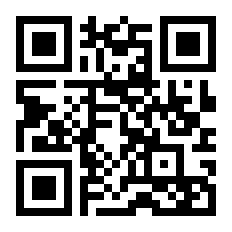

# Add me on LinkedIn
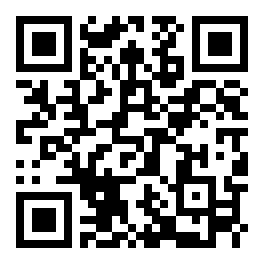